Large architecture: not really overfitting, more just undertraining? Scan over constant number of weights and biases?
Visualise Legendre patterns being picked up on? You shouldn't be able to train the same set, if you randomly permute the labels. "A closer look at memorisation in deep networks"

Reducing dimensionality is good, because it might speed up convergence during training, but also because it reduces noise so increases robustness against overfitting.
Decomps don't have to be good, they just have to be unique.

Implement tips from https://karpathy.github.io/2019/04/25/recipe/

**KEEP SET SEPARATE TO TEST AFTER HYPERPARAMETER TUNING!!!** Train/validation/test split.

* **Compare (in terms of time taken)**
    * pixels (find better downsampling). Only use Legendre for downsampling? ("We can do most of the work before we even see the training set")
        * We don't get it perfect even with 28X28. The Legendre polynomials won't like sharp changes or the empty edges.
        * Very fast, recon doesn't matter, only distinctiveness.
    * PCA
    * Legendre coeffs (10 by 10 decomp of full pixel grid, say. Doesn't need to recomp well, just needs to be distinct.)
        * Why not a Fourier transform?
* **Compare (in terms of time taken and score)**
    * MLPClassifier (simple as possible)
    * MLPClassifier (slightly more complex)
    * SVC
    * XGBoost
    * KMeans
    * GMM (interpret probabilities)
* Repeat for some other dataset?

**Preproc: Leg, PCA, nothing, random pertmutation.
Classifiers: MLP, SVC, XGBoost (just on full?)**

Can I define a Legendre function to put in a pipeline?

Unsupervised MNIST, how many real classes?

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.special import eval_legendre
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from time import time

In [2]:
name = 'mnist_784'
mnist = fetch_openml(name, data_home='~/scikit_learn_data/openml/'+name)
N1 = 28

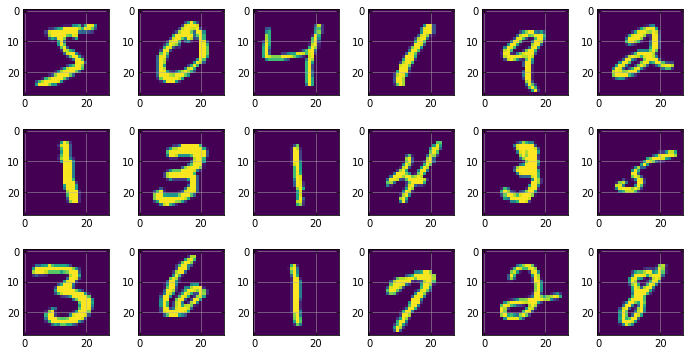

255.0
0.0


In [3]:
fig, axs = plt.subplots(3,6,figsize=(12,6))
axs = axs.flatten()
N_plot = len(axs)
for i in range(N_plot):
    axs[i].imshow(mnist.data.values[i].reshape((N1,N1)))
plt.show()
print(np.max(mnist.data.values))
print(np.min(mnist.data.values))

In [4]:
X = mnist['data'].values
y = mnist['target']
test_size = 0.5
X_train, X_nottrain, y_train, y_nottrain = train_test_split(X, y, test_size=test_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=0.5, random_state=43)
print([np.shape(grp) for grp in [X_train, X_valid, X_test]])

[(35000, 784), (17500, 784), (17500, 784)]


In [5]:
## # List classifiers
## # List preproc pipes

hidden_layer_sizes = [120]
method_name, method = 'mlp', MLPClassifier
method_params = {'hidden_layer_sizes':hidden_layer_sizes, 'activation':'relu', 'random_state':16, 'tol':1e-6, 'learning_rate_init':1e-4, 'max_iter':500}

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

"max_iter: int, default=200

Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps."

In [6]:
pca_results = []
for sqrt_n_components in range(1,22,2):
    n_components = sqrt_n_components**2
    t1 = time()
    pca = PCA(n_components=n_components, random_state=42)
    pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), (method_name, method(**method_params))])
    pca_pipe.fit(X_train, y_train)
    t2 = time()
    
    score_valid = pca_pipe.score(X_valid, y_valid)
    score_train = pca_pipe.score(X_train, y_train)
    pca_results.append([n_components, score_valid, score_train, t2-t1])
    print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
pca_results = np.array(pca_results)
"""25	0.9596571428571429	0.9988	66.09388494491577
49	0.9676571428571429	0.9996571428571429	46.0301456451416
81	0.9693142857142857	0.9997428571428572	34.43857288360596"""

1	0.3064571428571429	0.3042	90.63547897338867


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


9	0.8941142857142858	0.9104	77.0533504486084


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


25	0.9622285714285714	0.9895714285714285	140.06976318359375


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


49	0.9678285714285715	0.9998857142857143	152.43305349349976


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


81	0.9687428571428571	0.9999714285714286	163.56610202789307
121	0.9711428571428572	1.0	167.26015448570251
169	0.9707428571428571	0.9999714285714286	151.87462496757507
225	0.9680571428571428	1.0	126.31170082092285
289	0.9679428571428571	1.0	122.5418872833252
361	0.9652571428571428	1.0	125.94089007377625
441	0.9653142857142857	1.0	134.03203868865967


'25\t0.9596571428571429\t0.9988\t66.09388494491577\n49\t0.9676571428571429\t0.9996571428571429\t46.0301456451416\n81\t0.9693142857142857\t0.9997428571428572\t34.43857288360596'

[0.98383372 0.98818695 0.9512605  0.94466403 0.96867322 0.96052632
 0.97200448 0.96310573 0.95604396 0.9622432 ]


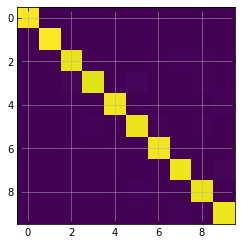

0.984	0.0	0.002	0.0	0.002	0.003	0.002	0.001	0.003	0.002	
0.0	0.988	0.004	0.003	0.0	0.001	0.0	0.001	0.003	0.001	
0.001	0.006	0.951	0.007	0.006	0.001	0.005	0.011	0.009	0.004	
0.002	0.001	0.012	0.945	0.001	0.018	0.001	0.007	0.008	0.007	
0.002	0.006	0.004	0.001	0.969	0.001	0.002	0.003	0.002	0.011	
0.002	0.003	0.001	0.009	0.003	0.961	0.009	0.001	0.009	0.003	
0.006	0.003	0.004	0.001	0.005	0.004	0.972	0.002	0.003	0.001	
0.001	0.007	0.007	0.002	0.005	0.001	0.0	0.963	0.0	0.014	
0.002	0.004	0.005	0.007	0.003	0.009	0.007	0.002	0.956	0.004	
0.003	0.003	0.004	0.004	0.007	0.005	0.001	0.008	0.004	0.962	


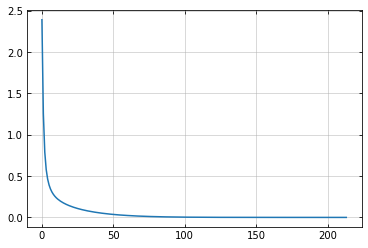

In [7]:
con = confusion_matrix(y_valid, pca_pipe.predict(X_valid), normalize='true')
print(np.diag(con))
plt.imshow(con)
plt.show()
for a in con:
    for b in a:
        print(round(b,3), end='\t')
    print('')
plt.plot(pca_pipe[method_name].loss_curve_)
plt.show()

In [8]:
## # Full
n_components = X_valid.shape[1]
print(n_components)
t1 = time()
full_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
full_pipe.fit(X_train, y_train)
t2 = time()
score_valid = full_pipe.score(X_valid, y_valid)
score_train = full_pipe.score(X_train, y_train)
full_result = [n_components, score_valid, score_train, t2-t1]
print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)

784
784	0.9702285714285714	1.0	166.95104551315308


In [9]:
## # Move to end?
methods = [XGBClassifier, LinearSVC, GradientBoostingClassifier]#, SVC]
mthd_params = dict()
mthd_params[LinearSVC.__name__] = {'max_iter':2000}
mthd_params[XGBClassifier.__name__] = {'use_label_encoder':True, "objective":"multi:softmax","num_class":10}#, "eval_metric":"merror"}
mthd_params[GradientBoostingClassifier.__name__] = {}
N_samples_cut = {LinearSVC.__name__:10000, XGBClassifier.__name__:10000, GradientBoostingClassifier.__name__:5000}
## # Bad naming - need to clean up method vs mthd.
mthd_results = []
#print(help(XGBClassifier.score))
for mthd in methods:
    #print(mthd.__name__, end='\t', flush=True)
    n_components = X_valid.shape[1]
    t1 = time()
    #print(np.shape(X_train[:100,:100]))
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**mthd_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    #print(X_train[:cut][:10].sum())
    #print(y_train[:cut][:10].values)
    if mthd.__name__=='XGBClassifier':
        mthd_pipe.fit(X_train[:cut], y_train[:cut].astype("category"))
    else:
        mthd_pipe.fit(X_train[:cut], y_train[:cut])
    t2 = time()
    #print(mthd_pipe.predict(X_valid[:10]))
    #print(y_valid[:10].values)
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        temp = mthd_pipe.predict(X_valid[:cut])
        #acc_count = np.shape(np.where(y_train[:cut].astype(np.int64)==temp))
        #print(acc_count, cut)
        #print([int(x) for x in temp[:15]])
        #print(y_valid[:15].astype(np.int64).values)
        score_valid = mthd_pipe.score(X_valid[:cut], y_valid[:cut])#pd.get_dummies(y_valid[:cut].astype(np.int64)))
        score_train = mthd_pipe.score(X_train[:cut], y_train[:cut])#pd.get_dummies(y_train[:cut].astype(np.int64)))
    else:
        score_valid = mthd_pipe.score(X_valid[:cut], y_valid[:cut])
        score_train = mthd_pipe.score(X_train[:cut], y_train[:cut])
    mthd_results.append([n_components, score_valid, score_train, t2-t1])
    print(mthd.__name__, cut, score_valid, score_train, round((t2-t1),2), sep='\t', flush=True)

/home/clarkeph/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier	10000	0.9529	1.0	80.43
LinearSVC	10000	0.8595	0.977	49.95


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GradientBoostingClassifier	5000	0.9188	0.9992	211.11


In [10]:
## # Random (no signal, all noise)
n_components = X_valid.shape[1]
print(n_components)
t1 = time()
rand_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
permed_train = permutation(y_train)
rand_pipe.fit(X_train, permed_train)
t2 = time()
score_valid = -1
score_train = rand_pipe.score(X_train, permed_train)
rand_result = [n_components, score_valid, score_train, t2-t1]
print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)

784


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


784	-1	0.6119714285714286	400.3917944431305


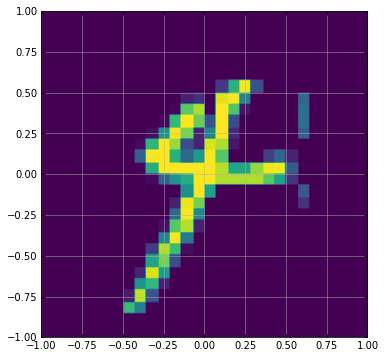

0 1.0
1 0.9999999999999999
2 1.0037590503817837
3 0.7933329939388579
4 0.7901851359148608
5 0.7100601166731039
6 0.6973254231113007
7 0.6737486892288512
8 0.6646175211985763
9 0.6565183319173374
10 0.6507561846045818
11 0.6458972115556915
12 0.6442148826523005
13 0.6390246554531077
14 0.640770654304066
15 0.6366692488556117
16 0.6380344931421416
17 0.6367394756219809
18 0.6379121678739106
19 0.637758728644326
20 0.6388967845207749
21 0.6393387039497155
22 0.6407722169722738
23 0.6418681410481251
24 0.6432750415832559
25 0.6447130367141306
26 0.6457245365600132
27 0.6465419757687355
28 0.6470939094501874

 3.4698557956389524


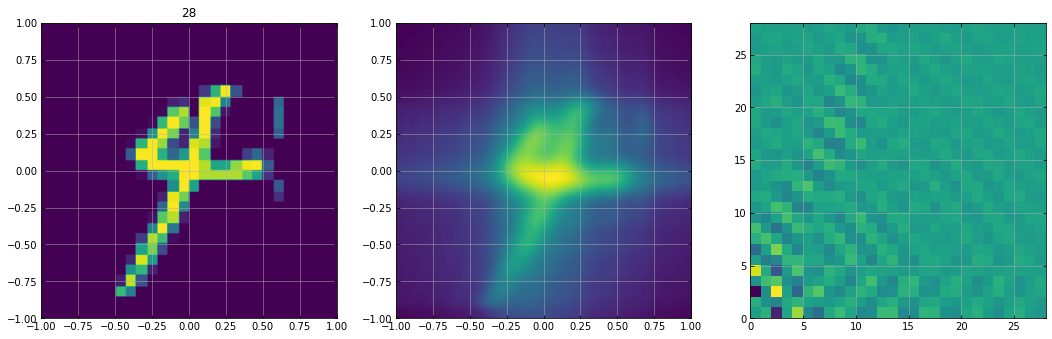

In [11]:
## # 2d
N_pixel = 28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])
mnist_ind = 53
to_fit = mnist['data'].values[mnist_ind].reshape((28,28))
to_fit -= to_fit.mean()
to_fit = to_fit/to_fit.std()
#print(breaks)
def func(x, y):
    x = np.clip(np.ceil((1+x)*N_pixel/2), 0, 27)
    y = np.clip(np.ceil((1+y)*N_pixel/2), 0, 27)
    temp = to_fit[y.astype(np.int64), x.astype(np.int64)]
    return temp

N_plot = 150
xs = np.linspace(-1, 1, N_plot, endpoint=True)
ys = np.linspace(-1, 1, N_plot, endpoint=True)
f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
fns = func(f_xs, f_ys)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
plt.show()

N = 101
Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]
for Nmax in range(29):#range(1,32,10):
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    #print(np.shape(coeffs))
        
    N_plot = 150
    xs = np.linspace(-1, 1, N_plot, endpoint=True)
    ys = np.linspace(-1, 1, N_plot, endpoint=True)
    f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
    fns = func(f_xs, f_ys)
    recomp = np.dot(coeffs, [eval_legendre(n, xs) for n in range(Nmax)])
    #print(1, np.shape(recomp))
    recomp = np.dot(recomp.T, [eval_legendre(n, xs) for n in range(Nmax)]).flatten()
    #print(2, np.shape(recomp))
    print(Nmax, np.sum((recomp-fns)**2)/np.sum(fns**2))
print('\n',np.sum(coeffs**2))
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].set_title(Nmax)
axs[0].imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
axs[1].imshow(recomp.reshape((N_plot, N_plot)), label='recomp', extent=[-1, 1, -1, 1])
axs[2].imshow(coeffs[::-1,:], extent=[0, Nmax, 0, Nmax])
plt.show()

[[-1.31838984e-16  8.09519139e-02 -5.23429828e-01]
 [ 6.95509592e-02 -7.27291858e-02 -1.28337740e-01]
 [-6.31614153e-01 -7.83000888e-02  4.78902402e-01]]
[[-0.00326725  0.00071266  0.01363319]
 [ 0.00860681 -0.00146517  0.00054285]
 [ 0.00292236 -0.00426319 -0.00824053]]


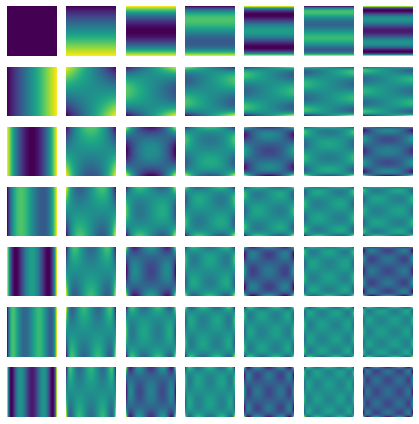

In [12]:
print(coeffs[:3,:3])
print(coeffs[-3:,-3:])
N_plot = 101
ps = np.linspace(-1, 1, N_plot, endpoint=True)
xs, ys = np.meshgrid(ps, ps)[0].flatten(), np.meshgrid(ps, ps)[1].flatten()
Nmax_plot = 7
fig, axs = plt.subplots(Nmax_plot, Nmax_plot, figsize=(6,6))
for n1 in range(Nmax_plot):
    temp = eval_legendre(n1, xs)*np.sqrt(n1+0.5)
    for n2 in range(Nmax_plot):
        temp2 = temp*eval_legendre(n2, ys)*np.sqrt(n2+0.5)
        #axs[n1][n2].set_title(f'{n1}, {n2}')
        axs[n1][n2].imshow(temp2.reshape((N_plot,N_plot)))
        axs[n1][n2].axis('off')
plt.tight_layout()
plt.show()

In [13]:
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])
#Nmax = 15#28

Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]

leg_results = []
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
for Nmax in range(1, 22, 2):
    t1 = time()
    ## # Converting pixel features to Legendre features,
    ## # reducing dimensionality and smoothing.
    ## # Training set:
    leg_features = []
    for to_fit in X_train_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_features.append(coeffs.flatten())
    leg_features = np.array(leg_features)

    ## # Fitting the model
    leg_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
    leg_pipe.fit(leg_features, y_train)
    t2 = time()
    
    ## # Validation set:
    leg_valid = []
    for to_fit in X_valid_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_valid.append(coeffs.flatten())
    leg_valid = np.array(leg_valid)
    score_valid = leg_pipe.score(leg_valid, y_valid)
    score_train = leg_pipe.score(leg_features, y_train)
    leg_results.append([Nmax**2, score_valid, score_train, t2-t1])
    print(Nmax**2, score_valid, score_train, t2-t1, sep='\t', flush=True)

1	0.2332	0.23005714285714285	39.85886812210083


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


9	0.798	0.8067428571428571	74.4466757774353


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


25	0.9386285714285715	0.9533428571428572	138.33995532989502


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


49	0.9640571428571428	0.9824857142857143	149.93924617767334


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


81	0.9698285714285714	0.9968571428571429	162.36774158477783


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


121	0.9745714285714285	1.0	175.12446928024292


/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


169	0.9768571428571429	1.0	190.23734402656555
225	0.9743428571428572	1.0	167.1705288887024
289	0.9739428571428571	1.0	146.3099763393402
361	0.9712571428571428	1.0	133.45606303215027
441	0.9688571428571429	1.0	132.36248183250427


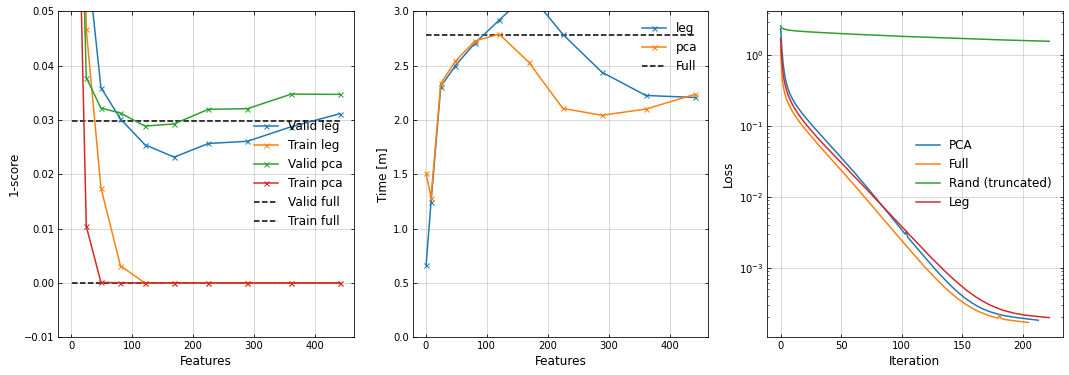

Final value of rand loss: 500 iterations gives loss=1.23.


In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot([r[0] for r in leg_results], [1-r[1] for r in leg_results], '-x', label='Valid leg')
axs[0].plot([r[0] for r in leg_results], [1-r[2] for r in leg_results], '-x', label='Train leg')
axs[1].plot([r[0] for r in leg_results], [r[3]/60 for r in leg_results], '-x', label='leg')
axs[0].plot([r[0] for r in pca_results], [1-r[1] for r in pca_results], '-x', label='Valid pca')
axs[0].plot([r[0] for r in pca_results], [1-r[2] for r in pca_results], '-x', label='Train pca')
axs[1].plot([r[0] for r in pca_results], [r[3]/60 for r in pca_results], '-x', label='pca')
xmin, xmax = min(pca_results[:,0]), max(pca_results[:,0])
axs[0].hlines(1-full_result[1], xmin, xmax, linestyles='--', label='Valid full')
axs[0].hlines(1-full_result[2], xmin, xmax, linestyles='--', label='Train full')
axs[1].hlines(full_result[3]/60, xmin, xmax, linestyles='--', label='Full')
axs[2].plot(pca_pipe[method_name].loss_curve_, '-', label='PCA')
axs[2].plot(full_pipe[method_name].loss_curve_, '-', label='Full')
axs[2].plot(rand_pipe[method_name].loss_curve_[:len(leg_pipe[method_name].loss_curve_)], '-', label='Rand (truncated)')
axs[2].plot(leg_pipe[method_name].loss_curve_, '-', label='Leg')
axs[2].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_xlabel('Features')
axs[0].set_ylabel('1-score')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Time [m]')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Iteration')
axs[0].set_ylim(-0.01, 0.05)
axs[1].set_ylim(0, 3.)
plt.show()
print(f"Final value of rand loss: {len(rand_pipe[method_name].loss_curve_)} iterations gives loss={round(rand_pipe[method_name].loss_curve_[-1],2)}.")

Using all the features leads to overfitting. PCA helps, but since the features are picked based on variance they might not actually hold the cluster information. Legendre coefficients as features cut out noise, but can also make use of more features before giving in to overfitting, hence achieve a better validation score (though the difference is only marginal, 97.55% compared to 97.07%).

Don't have to reconstruct, just have to be distinct.

Interpret loss curve. Spikes are probably from weird batches, making the learning rate smaller shrinks them. We only go up to 21X21 features so PCA and Legendre curves don't match Full.

Do grand finale, pick features and check on test set.